The objective here to generate four box-and-whisker graphs:

- CF by team (by game) in 2016-17
- CF by team (by game) in 2017-18
- CA by team (by game) in 2016-17
- CA by team (by game) in 2017-18

In [1]:
import pandas as pd
from pylab import *
%matplotlib inline
import seaborn as sns
import os.path
sns.set()
sns.reset_orig()  # want to use matplotlib style, not seaborn style

import scrapenhl2.scrape.team_info as team_info
import scrapenhl2.scrape.schedules as schedules
import scrapenhl2.scrape.teams as teams
import scrapenhl2.manipulate.manipulate as manip

To aggregate data, loop over both seasons. In each season, loop over each team. Read in its season PBP, filter for Corsi events, group by game and acting team and sum. Then, go long to wide, so each row is a game.

Aggregate over teams, add a flag for whether the team is the Caps--we need this for the graph below--and we're good to go.

In [2]:
dflst = {2016: [], 2017: []}
for season in dflst.keys():
    for team in schedules.get_teams_in_season(season):
        if not os.path.exists(teams.get_team_pbp_filename(season, team)):
            continue
        df = teams.get_team_pbp(season, team)
        df = manip.filter_for_corsi(df)
        df.loc[:, 'Team2'] = df.Team.apply(lambda x: 'CF' if x == team else 'CA')
        df = df[['Team2', 'Game']] \
            .query("Game <= 21230") \
            .assign(Count=1) \
            .groupby(['Team2', 'Game']) \
            .count() \
            .pivot_table(index='Game', columns='Team2', values='Count') \
            .reset_index() \
            .assign(Team=team_info.team_as_str(team), Season=season)
        dflst[season].append(df)
    df = pd.concat(dflst[season])
    df.loc[:, 'IsWSH'] = df.Team.apply(lambda x: x == 'WSH')
    dflst[season] = df
print(dflst[2017].head())

Team2   Game  CA  CF  Season Team  IsWSH
0      20019  62  62    2017  NJD  False
1      20046  79  50    2017  NJD  False
2      20058  52  46    2017  NJD  False
3      20065  64  47    2017  NJD  False
4      20081  76  68    2017  NJD  False


We want to order teams in each graph by the median. That means we'll be comaparing horizontal positions of the Caps' box-and-whisker--meaning we should arrange 2016-17 on top and 2017-18 on the bottom.

To get all this to work I use a little trickery with modulus and integer division. But it's straightforward to brute-force this as well (it's only four axes).

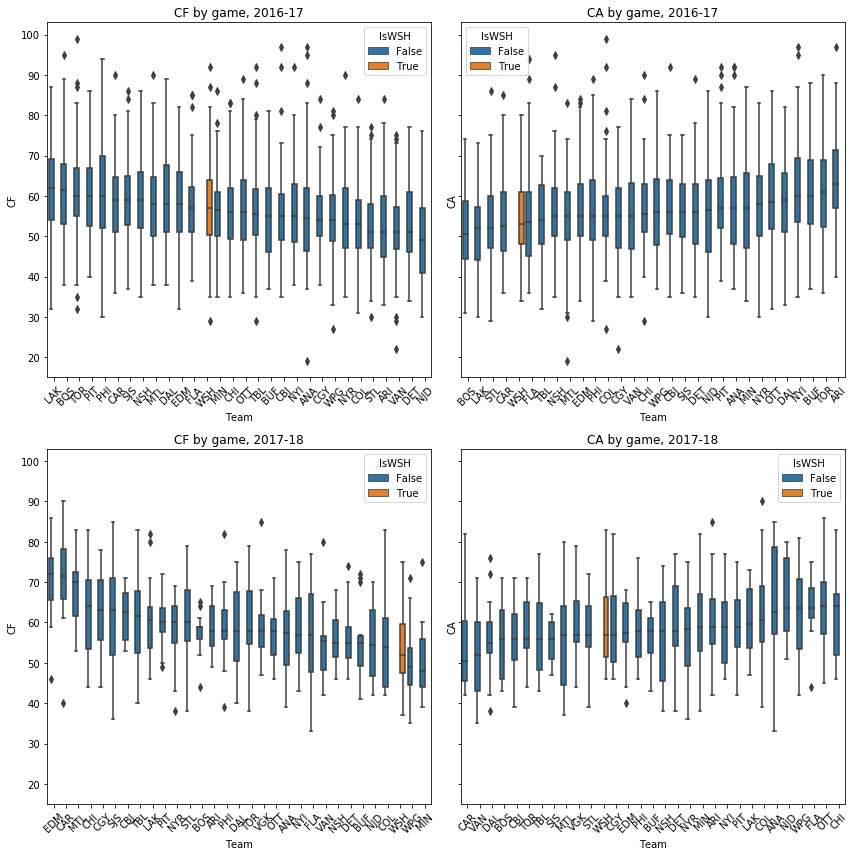

In [3]:
fig, axes = subplots(2, 2, sharey=True, figsize=[12, 12])
axes = axes.flatten()
xticks(rotation=45)
for i in range(4):
    season = 2016 + i // 2
    df = dflst[season]
    if i % 2 == 0:
        order = df[['Team', 'CF']].groupby('Team').median().sort_values('CF', ascending=False).index
        sns.boxplot(x='Team', y='CF', hue='IsWSH', order=order, data=df, ax=axes[i])
    else:
        order = df[['Team', 'CA']].groupby('Team').median().sort_values('CA').index
        sns.boxplot(x='Team', y='CA', hue='IsWSH', order=order, data=df, ax=axes[i])
    if i % 2 == 0:
        axes[i].set_title('CF by game, {0:d}-{1:s}'.format(season, str(season + 1)[2:]))
    else:
        axes[i].set_title('CA by game, {0:d}-{1:s}'.format(season, str(season + 1)[2:]))
    setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

fig.tight_layout()